Goal: To use classification ML to optimize the Driver selection for orders in the OnlineTaxi application. Main goal is to increase the conversion rate by choosing the right driver, compared to the default or previous algorithm, which could be route based only. Other goals would be to decrease the pickup time, and possibly the total time, which would be a regression problem. For now I will concentrate on the main goal, keeping in mind that we may decide to include the other goals in the selection process, increasing the complexity of the solution.

To perform the classification ML, I will need to create a training data set from the participant and booking log files. This dataset schema needs to match the same format as the test dataset but with one extra column, the label column. The label will indicate a transaction that was COMPLETED=>True or NOT COMPLETED=>False. I loaded the datasets from Google to my local pc. Later I decided to keep all records that failed, including the ones where multiple drivers were selected by the experiment algorithm. I kept these because those drivers that rejected or ignored the order may be part of the reason the order failed. I only removed the records for drivers that did not accept, but the transaction was successful using a different driver. See note below for more details.


In [1]:
import pandas as pd
import datetime as dt
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight

First step is to import the data

In [2]:
df_booking = pd.read_csv("booking_log_clean.csv")
df_participant = pd.read_csv("participant_log_clean.csv")
df_testdata = pd.read_csv("test_data.csv")

Look at the data for anamolies

In [3]:
df_booking.describe()

,order_id,customer_id,driver_id,trip_distance,pickup_latitude,pickup_longitude
count,6.981410e+05,6.981410e+05,6.981410e+05,698141.000000,698141.000000,698141.000000
mean,5.504373e+11,5.498243e+11,3.993389e+11,3.995701,-2.968284,104.755900
std,2.595616e+11,2.595928e+11,3.325674e+11,3.059185,0.028993,0.028344
min,1.000046e+11,1.000022e+11,0.000000e+00,0.001000,-3.077437,104.608508
25%,3.254725e+11,3.251339e+11,0.000000e+00,1.754000,-2.987763,104.740030
50%,5.507460e+11,5.489496e+11,3.789967e+11,3.120000,-2.971225,104.756480
75%,7.754378e+11,7.755845e+11,6.951609e+11,5.438000,-2.950474,104.773200
max,9.999956e+11,9.999882e+11,9.999924e+11,29.730000,-2.648479,104.991344


In [4]:
df_participant.describe()

,driver_id,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy
count,4.001040e+05,4.001040e+05,4.001040e+05,400104.000000,400104.000000,400104.000000
mean,5.530355e+11,5.501855e+11,5.500994e+11,-2.968413,104.756180,35.392805
std,2.613907e+11,2.595957e+11,2.596621e+11,0.028404,0.027576,202.351923
min,1.000498e+11,1.000046e+11,1.000062e+11,-3.065749,104.612203,0.001000
25%,3.253827e+11,3.253535e+11,3.253740e+11,-2.987754,104.740567,3.887000
50%,5.510014e+11,5.508804e+11,5.498584e+11,-2.971223,104.756633,6.068000
75%,7.794386e+11,7.749107e+11,7.748903e+11,-2.951060,104.772938,16.000000
max,9.999924e+11,9.999956e+11,9.999971e+11,-2.849100,104.868650,9344.225000


In [5]:
df_testdata.describe()

,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,5.006333e+11,5.525144e+11,3.969944,-2.970818,104.757115,5.555315e+11,-2.970834,104.757117,37.876704
std,2.302127e+11,2.618832e+11,3.014551,0.026492,0.025101,2.605722e+11,0.026312,0.024975,202.782049
min,1.000422e+11,1.000022e+11,0.004000,-3.052417,104.647446,1.003707e+11,-3.053791,104.638556,0.010000
25%,3.029653e+11,3.179292e+11,1.708000,-2.988464,104.741887,3.316509e+11,-2.988418,104.742138,3.900000
50%,5.002720e+11,5.586124e+11,3.103500,-2.974382,104.757789,5.574468e+11,-2.974645,104.757860,6.819000
75%,7.007568e+11,7.816167e+11,5.505500,-2.953753,104.772782,7.826103e+11,-2.954101,104.772031,19.296000
max,8.992314e+11,9.999808e+11,24.865000,-2.892498,104.825707,9.999924e+11,-2.890716,104.829239,9452.022000


verify data was loaded correctly

In [6]:
print(df_participant.head(2))
df_testdata.dtypes
print(df_booking.head(2))
df_testdata.dtypes
print(df_testdata.head(2))
df_testdata.dtypes

       event_timestamp     driver_id participant_status      order_id  \
0  2015-05-18 11:45:19  110283102582            CREATED  938125906616   
1  2015-05-18 11:45:29  110283102582           ACCEPTED  938125906616   

   experiment_key  driver_latitude  driver_longitude  driver_gps_accuracy  
0    309579604593        -2.981389        104.761898                  2.0  
1    309579604593        -2.981389        104.761898                  2.0  
       event_timestamp      order_id booking_status   customer_id  \
0  2015-05-12 05:25:23  102254181112        CREATED  715281995014   
1  2015-05-12 05:25:24  102254181112   DRIVER_FOUND  715281995014   

      driver_id  trip_distance  pickup_latitude  pickup_longitude  
0             0            2.0        -2.998461        104.788077  
1  221172732473            2.0        -2.998461        104.788077  
               event_timestamp      order_id   customer_id  trip_distance  \
0  2015-05-20 05:31:12.822 UTC  300202530411  470195505600     

event_timestamp         object
order_id                 int64
customer_id              int64
trip_distance          float64
pickup_latitude        float64
pickup_longitude       float64
driver_id                int64
driver_latitude        float64
driver_longitude       float64
driver_gps_accuracy    float64
dtype: object

want to do some datetime manipulation later, so convert the event_timestamp from object to datetime data type

In [7]:
df_booking['event_timestamp'] = df_booking['event_timestamp'].str.slice(start=0, stop=19, step=1).apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_participant['event_timestamp'] = df_participant['event_timestamp'].str.slice(start=0, stop=19, step=1).apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_testdata['event_timestamp'] = df_testdata['event_timestamp'].str.slice(start=0, stop=19, step=1).apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

df_testdata['created_hr'] = df_testdata['event_timestamp'].dt.hour
df_testdata['created_day'] = df_testdata['event_timestamp'].dt.weekday

df_testdata.dtypes

event_timestamp        datetime64[ns]
order_id                        int64
customer_id                     int64
trip_distance                 float64
pickup_latitude               float64
pickup_longitude              float64
driver_id                       int64
driver_latitude               float64
driver_longitude              float64
driver_gps_accuracy           float64
created_hr                      int64
created_day                     int64
dtype: object

verify there are 10 rows/drivers for each order_id as advertised

In [8]:
df_testdata.groupby(['order_id']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

,order_id,size
0,100042151807,10
6670,633543743216,10
6663,633060525013,10
6664,633199160804,10
6665,633249797111,10
...,...,...
3333,369603923011,10
3334,369641306108,10
3335,369896109511,10
3336,370102015406,10


In [9]:
df_testdata.query('order_id == "300202530411"')

,event_timestamp,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,created_hr,created_day
0,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,578486386000,-2.979892,104.775853,104.100,5,2
1,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,919898718450,-2.979352,104.772134,22.235,5,2
2,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,566354734208,-2.978990,104.778163,3.900,5,2
3,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,996326998494,-2.979434,104.775919,3.000,5,2
4,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,110774820109,-2.979365,104.776071,4.288,5,2
5,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,689390484756,-2.979205,104.776172,23.752,5,2
6,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,955728734151,-2.979360,104.775866,86.000,5,2
7,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,377134783300,-2.979331,104.775950,5.744,5,2
8,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,680922346941,-2.978465,104.775663,23.000,5,2
9,2015-05-20 05:31:12,300202530411,470195505600,2.0,-2.977965,104.77559,200300595326,-2.974705,104.777477,75.344,5,2


check for any nulls (booking and participant were cleaned earlier, in assignment1)

In [10]:
null_columns=df_testdata.columns[df_testdata.isnull().any()]
df_testdata[null_columns].isnull().sum()

Series([], dtype: float64)

look for duplicate order and driver combinations

In [11]:
df_testdata.groupby(['order_id','driver_id']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

,order_id,driver_id,size
97364,877884038107,822831996763,4
640,105988374713,308640691442,4
642,105988374713,349289374200,4
29394,337010157416,101253645388,4
29395,337010157416,277322749405,4
...,...,...,...
33325,369603923011,796270433976,1
33324,369603923011,540983807470,1
33323,369603923011,539919422297,1
33322,369603923011,488126315747,1


look at one of the duplicates

In [12]:
df_testdata.query('order_id == 877884038107 and driver_id == 822831996763')

,event_timestamp,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,created_hr,created_day
28861,2015-05-20 10:03:00,877884038107,237708308228,9.936,-2.957177,104.809884,822831996763,-2.962193,104.809575,3.9,10,2
28862,2015-05-20 10:03:00,877884038107,237708308228,9.936,-2.957177,104.809884,822831996763,-2.962193,104.809575,3.9,10,2
28863,2015-05-20 10:03:00,877884038107,237708308228,9.936,-2.957177,104.809884,822831996763,-2.962193,104.809575,3.9,10,2
28866,2015-05-20 10:03:00,877884038107,237708308228,9.936,-2.957177,104.809884,822831996763,-2.962193,104.809575,3.9,10,2


these are duplicates so need to delete all duplicate records

In [13]:
df_testdata.drop_duplicates(subset=None, keep='first', inplace=True)

need to pivot tables before merging

In [14]:
df_booking

,event_timestamp,order_id,booking_status,customer_id,driver_id,trip_distance,pickup_latitude,pickup_longitude
0,2015-05-12 05:25:23,102254181112,CREATED,715281995014,0,2.000,-2.998461,104.788077
1,2015-05-12 05:25:24,102254181112,DRIVER_FOUND,715281995014,221172732473,2.000,-2.998461,104.788077
2,2015-05-12 05:55:10,102254181112,COMPLETED,715281995014,221172732473,2.000,-2.998461,104.788077
3,2015-05-12 05:29:37,105520285203,CREATED,957980952237,0,2.000,-2.970621,104.756226
4,2015-05-12 05:29:38,105520285203,DRIVER_FOUND,957980952237,527672421312,2.000,-2.970621,104.756226
...,...,...,...,...,...,...,...,...
698136,2015-05-18 10:22:01,995905396208,CUSTOMER_CANCELLED,366602285072,614972834584,9.916,-2.986197,104.761670
698137,2015-05-18 15:04:32,997608900030,CREATED,587801587010,0,9.916,-2.979303,104.745228
698138,2015-05-18 15:04:33,997608900030,DRIVER_FOUND,587801587010,439566211433,9.916,-2.979303,104.745228
698139,2015-05-18 15:10:44,997608900030,PICKED_UP,587801587010,439566211433,9.916,-2.979303,104.745228


In [15]:
df_booking_pivot = df_booking.pivot_table(index=['order_id','customer_id','driver_id','trip_distance','pickup_latitude','pickup_longitude'], columns=['booking_status'], values='event_timestamp', aggfunc='min')
df_booking_pivot

booking_status                                                                                  COMPLETED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                       
100004630900 407518871636 0            1.006         -2.961099       104.783248                       NaT   
                          576094811632 1.006         -2.961099       104.783248       2015-05-12 00:27:09   
100005695817 236584087567 0            1.147         -2.983429       104.764502                       NaT   
                          100995600755 1.147         -2.983429       104.764502       2015-05-16 02:21:07   
100021292050 783638744710 0            0.916         -2.979492       104.725380                       NaT   
...                                                                                                   ...   
999990809802 279880061968 505283434541 1.692         -2.935887       104.768610       2015-05-17 16:40:02   
999995536413 388173736702 0            2.103         -2.987742       104.754027                       NaT   
                          296006164700 2.103         -2.987742       104.754027       2015-05-10 07:01:29   
999995637211 223476004540 0            11.848        -2.981028       104.767074                       NaT   
                          640314257845 11.848        -2.981028       104.767074                       NaT   

booking_status                                                                                    CREATED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                       
100004630900 407518871636 0            1.006         -2.961099       104.783248       2015-05-12 00:21:29   
                          576094811632 1.006         -2.961099       104.783248                       NaT   
100005695817 236584087567 0            1.147         -2.983429       104.764502       2015-05-16 02:09:16   
                          100995600755 1.147         -2.983429       104.764502                       NaT   
100021292050 783638744710 0            0.916         -2.979492       104.725380       2015-05-10 13:26:24   
...                                                                                                   ...   
999990809802 279880061968 505283434541 1.692         -2.935887       104.768610                       NaT   
999995536413 388173736702 0            2.103         -2.987742       104.754027       2015-05-10 06:53:10   
                          296006164700 2.103         -2.987742       104.754027                       NaT   
999995637211 223476004540 0            11.848        -2.981028       104.767074       2015-05-11 10:24:49   
                          640314257845 11.848        -2.981028       104.767074                       NaT   

booking_status                                                                        CUSTOMER_CANCELLED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                      
100004630900 407518871636 0            1.006         -2.961099       104.783248                      NaT   
                          576094811632 1.006         -2.961099       104.783248                      NaT   
100005695817 236584087567 0            1.147         -2.983429       104.764502                      NaT   
                          100995600755 1.147         -2.983429       104.764502                      NaT   
100021292050 783638744710 0            0.916         -2.979492       104.725380                      NaT   
...                                                                                                  ...   
999990809802 279880061968 505283434541 1.692         -2.935887       104.768610                      NaT   
999995536413 388173736702 0            2.103         -2.987742       104.754027                      NaT   
                          296006164700 2.103         -2.987742       104.754027     

In [16]:
df_booking_pivot.groupby(['order_id']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

,order_id,size
0,100004630900,2
122439,693386117306,2
122465,693499232718,2
122466,693502600002,2
122467,693505061212,2
...,...,...
71254,445887373116,1
21403,204637868406,1
111301,639084438102,1
96935,570165076919,1


In [17]:
df_booking_pivot.query('order_id == 100004630900')

booking_status                                                                                  COMPLETED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                       
100004630900 407518871636 0            1.006         -2.961099       104.783248                       NaT   
                          576094811632 1.006         -2.961099       104.783248       2015-05-12 00:27:09   

booking_status                                                                                    CREATED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                       
100004630900 407518871636 0            1.006         -2.961099       104.783248       2015-05-12 00:21:29   
                          576094811632 1.006         -2.961099       104.783248                       NaT   

booking_status                                                                        CUSTOMER_CANCELLED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                      
100004630900 407518871636 0            1.006         -2.961099       104.783248                      NaT   
                          576094811632 1.006         -2.961099       104.783248                      NaT   

booking_status                                                                        DRIVER_CANCELLED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                    
100004630900 407518871636 0            1.006         -2.961099       104.783248                    NaT   
                          576094811632 1.006         -2.961099       104.783248                    NaT   

booking_status                                                                               DRIVER_FOUND  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                       
100004630900 407518871636 0            1.006         -2.961099       104.783248                       NaT   
                          576094811632 1.006         -2.961099       104.783248       2015-05-12 00:21:30   

booking_status                                                                        DRIVER_NOT_FOUND  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                    
100004630900 407518871636 0            1.006         -2.961099       104.783248                    NaT   
                          576094811632 1.006         -2.961099       104.783248                    NaT   

booking_status                                                                                  PICKED_UP  
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                      
100004630900 407518871636 0            1.006         -2.961099       104.783248                       NaT  
                          576094811632 1.006         -2.961099       104.783248       2015-05-12 00:23:40

In [18]:
df_participant

,event_timestamp,driver_id,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy
0,2015-05-18 11:45:19,110283102582,CREATED,938125906616,309579604593,-2.981389,104.761898,2.000
1,2015-05-18 11:45:29,110283102582,ACCEPTED,938125906616,309579604593,-2.981389,104.761898,2.000
2,2015-05-11 10:35:57,126346998414,CREATED,992080359113,941995970460,-2.966915,104.748040,2.000
3,2015-05-11 10:36:01,126346998414,ACCEPTED,992080359113,941995970460,-2.966915,104.748040,2.000
4,2015-05-16 12:34:20,199325048812,ACCEPTED,797723880713,197604093364,-3.014740,104.694647,2.000
...,...,...,...,...,...,...,...,...
400099,2015-05-17 04:57:32,868666321781,CREATED,807506644180,514465572244,-2.988325,104.763972,26.942
400100,2015-05-16 23:21:45,438082052422,CREATED,368974774419,701381598248,-2.985607,104.725295,27.942
400101,2015-05-16 23:21:46,438082052422,ACCEPTED,368974774419,701381598248,-2.985607,104.725295,27.942
400102,2015-05-15 01:01:54,689026016592,IGNORED,991540131701,746715283424,-3.035419,104.792624,79.893


In [19]:
df_participant_pivot = df_participant.pivot_table(index=['order_id','driver_id','experiment_key','driver_latitude','driver_longitude','driver_gps_accuracy'], columns=['participant_status'], values='event_timestamp', aggfunc='min')
df_participant_pivot

participant_status                                                                                       ACCEPTED  \
order_id     driver_id    experiment_key driver_latitude driver_longitude driver_gps_accuracy                       
100004630900 576094811632 729783043745   -2.960315       104.783728       7.000               2015-05-12 00:21:30   
100005695817 100995600755 596411113896   -2.983461       104.764434       6.607               2015-05-16 02:09:17   
100021292050 916245898577 915751718137   -2.979674       104.725359       0.010               2015-05-10 13:26:25   
100022287505 636669438942 271170430125   -2.975698       104.766467       23.725              2015-05-12 09:50:56   
100024200607 747772570290 998089677480   -2.928422       104.697199       98.772              2015-05-11 04:50:27   
...                                                                                                           ...   
999995536413 296006164700 121021626592   -2.986566       104.755194       8.716               2015-05-10 06:53:14   
999995637211 173842996771 177165267797   -2.976501       104.770708       11.653              2015-05-11 10:28:51   
             624115252932 418339787491   -2.983845       104.774263       3.900               2015-05-11 10:33:05   
             640314257845 168715586942   -2.974555       104.770578       26.804              2015-05-11 10:24:50   
             953134659073 177165267797   -2.983933       104.767252       12.000                              NaT   

participant_status                                                                                        CREATED  \
order_id     driver_id    experiment_key driver_latitude driver_longitude driver_gps_accuracy                       
100004630900 576094811632 729783043745   -2.960315       104.783728       7.000               2015-05-12 00:21:30   
100005695817 100995600755 596411113896   -2.983461       104.764434       6.607               2015-05-16 02:09:16   
100021292050 916245898577 915751718137   -2.979674       104.725359       0.010               2015-05-10 13:26:24   
100022287505 636669438942 271170430125   -2.975698       104.766467       23.725              2015-05-12 09:50:51   
100024200607 747772570290 998089677480   -2.928422       104.697199       98.772              2015-05-11 04:50:26   
...                                                                                                           ...   
999995536413 296006164700 121021626592   -2.986566       104.755194       8.716               2015-05-10 06:53:10   
999995637211 173842996771 177165267797   -2.976501       104.770708       11.653              2015-05-11 10:28:50   
             624115252932 418339787491   -2.983845       104.774263       3.900               2015-05-11 10:32:58   
             640314257845 168715586942   -2.974555       104.770578       26.804              2015-05-11 10:24:49   
             953134659073 177165267797   -2.983933       104.767252       12.000              2015-05-11 10:28:44   

participant_status                                                                            IGNORED  \
order_id     driver_id    experiment_key driver_latitude driver_longitude driver_gps_accuracy           
100004630900 576094811632 729783043745   -2.960315       104.783728       7.000                   NaT   
100005695817 100995600755 596411113896   -2.983461       104.764434       6.607                   NaT   
100021292050 916245898577 915751718137   -2.979674       104.725359       0.010                   NaT   
100022287505 636669438942 271170430125   -2.975698       104.766467       23.725                  NaT   
100024200607 747772570290 998089677480   -2.928422       104.697199       98.772                  NaT   
...                                                                                               ...   
999995536413 296006164700 121021626592   -2.986566       104.755194       8.716                   NaT   
99999563721

In [20]:
df_participant_pivot.query('order_id == "999995637211"')

participant_status                                                                                       ACCEPTED  \
order_id     driver_id    experiment_key driver_latitude driver_longitude driver_gps_accuracy                       
999995637211 173842996771 177165267797   -2.976501       104.770708       11.653              2015-05-11 10:28:51   
             624115252932 418339787491   -2.983845       104.774263       3.900               2015-05-11 10:33:05   
             640314257845 168715586942   -2.974555       104.770578       26.804              2015-05-11 10:24:50   
             953134659073 177165267797   -2.983933       104.767252       12.000                              NaT   

participant_status                                                                                        CREATED  \
order_id     driver_id    experiment_key driver_latitude driver_longitude driver_gps_accuracy                       
999995637211 173842996771 177165267797   -2.976501       104.770708       11.653              2015-05-11 10:28:50   
             624115252932 418339787491   -2.983845       104.774263       3.900               2015-05-11 10:32:58   
             640314257845 168715586942   -2.974555       104.770578       26.804              2015-05-11 10:24:49   
             953134659073 177165267797   -2.983933       104.767252       12.000              2015-05-11 10:28:44   

participant_status                                                                            IGNORED  \
order_id     driver_id    experiment_key driver_latitude driver_longitude driver_gps_accuracy           
999995637211 173842996771 177165267797   -2.976501       104.770708       11.653                  NaT   
             624115252932 418339787491   -2.983845       104.774263       3.900                   NaT   
             640314257845 168715586942   -2.974555       104.770578       26.804                  NaT   
             953134659073 177165267797   -2.983933       104.767252       12.000                  NaT   

participant_status                                                                                       REJECTED  
order_id     driver_id    experiment_key driver_latitude driver_longitude driver_gps_accuracy                      
999995637211 173842996771 177165267797   -2.976501       104.770708       11.653                              NaT  
             624115252932 418339787491   -2.983845       104.774263       3.900                               NaT  
             640314257845 168715586942   -2.974555       104.770578       26.804                              NaT  
             953134659073 177165267797   -2.983933       104.767252       12.000              2015-05-11 10:28:50

this order has 4 different drivers selected, 3 of which have an accepted datetime, look at the raw data table for verification

In [21]:
df_participant.query('order_id == "999995637211"').sort_values(['event_timestamp'], ascending=[True])

,event_timestamp,driver_id,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy
370959,2015-05-11 10:24:49,640314257845,CREATED,999995637211,168715586942,-2.974555,104.770578,26.804
370958,2015-05-11 10:24:50,640314257845,ACCEPTED,999995637211,168715586942,-2.974555,104.770578,26.804
83763,2015-05-11 10:28:44,953134659073,CREATED,999995637211,177165267797,-2.983933,104.767252,12.000
83762,2015-05-11 10:28:50,953134659073,REJECTED,999995637211,177165267797,-2.983933,104.767252,12.000
253930,2015-05-11 10:28:50,173842996771,CREATED,999995637211,177165267797,-2.976501,104.770708,11.653
253931,2015-05-11 10:28:51,173842996771,ACCEPTED,999995637211,177165267797,-2.976501,104.770708,11.653
175239,2015-05-11 10:32:58,624115252932,CREATED,999995637211,418339787491,-2.983845,104.774263,3.900
175238,2015-05-11 10:33:05,624115252932,ACCEPTED,999995637211,418339787491,-2.983845,104.774263,3.900


In [22]:
df_booking.query('order_id == "999995637211"').sort_values(['event_timestamp'], ascending=[True])

,event_timestamp,order_id,booking_status,customer_id,driver_id,trip_distance,pickup_latitude,pickup_longitude
678728,2015-05-11 10:24:49,999995637211,CREATED,223476004540,0,11.848,-2.981028,104.767074
678729,2015-05-11 10:24:50,999995637211,DRIVER_FOUND,223476004540,640314257845,11.848,-2.981028,104.767074


only one of the drivers actually show up in the booking table, under the DRIVER_FOUND status. Howver, there is no COMPLETED entry for this trip, so this one was a failure. Lets try to find a successful example to compare against.

In [23]:
df_booking.query('booking_status == "COMPLETED"')

,event_timestamp,order_id,booking_status,customer_id,driver_id,trip_distance,pickup_latitude,pickup_longitude
2,2015-05-12 05:55:10,102254181112,COMPLETED,715281995014,221172732473,2.000,-2.998461,104.788077
9,2015-05-18 04:46:36,113947347802,COMPLETED,352787792790,476656797665,2.000,-2.981196,104.718829
16,2015-05-15 09:20:19,209915120110,COMPLETED,725333969587,230098216348,2.000,-2.982890,104.738268
24,2015-05-16 05:52:30,298115671619,COMPLETED,715281995014,505029908985,2.000,-2.998464,104.788078
28,2015-05-14 09:11:35,318512932419,COMPLETED,129838375320,252025300486,2.000,-2.926193,104.714076
...,...,...,...,...,...,...,...,...
698114,2015-05-15 07:02:51,990607925005,COMPLETED,920854930417,937900793051,9.416,-2.996099,104.803379
698118,2015-05-11 09:01:04,252322698916,COMPLETED,931111095625,876544879544,9.916,-2.982943,104.759757
698124,2015-05-12 10:37:20,422773467408,COMPLETED,971831310784,778657820325,9.916,-2.999128,104.826549
698130,2015-05-11 07:10:20,883402014715,COMPLETED,535664745680,572762776255,9.916,-2.955886,104.799126


In [24]:
df_participant_pivot.query('order_id == "102254181112"')

,,,,,participant_status,ACCEPTED,CREATED,IGNORED,REJECTED
order_id,driver_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,,,,
102254181112,221172732473,697155500625,-2.998517,104.780779,123.623,2015-05-12 05:25:24,2015-05-12 05:25:24,NaT,NaT


In [25]:
df_participant.query('order_id == "102254181112"').sort_values(['event_timestamp'], ascending=[True])

,event_timestamp,driver_id,participant_status,order_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy
140129,2015-05-12 05:25:24,221172732473,CREATED,102254181112,697155500625,-2.998517,104.780779,123.623
140130,2015-05-12 05:25:24,221172732473,ACCEPTED,102254181112,697155500625,-2.998517,104.780779,123.623


In [26]:
df_booking.query('order_id == "102254181112"').sort_values(['event_timestamp'], ascending=[True])

,event_timestamp,order_id,booking_status,customer_id,driver_id,trip_distance,pickup_latitude,pickup_longitude
0,2015-05-12 05:25:23,102254181112,CREATED,715281995014,0,2.0,-2.998461,104.788077
1,2015-05-12 05:25:24,102254181112,DRIVER_FOUND,715281995014,221172732473,2.0,-2.998461,104.788077
2,2015-05-12 05:55:10,102254181112,COMPLETED,715281995014,221172732473,2.0,-2.998461,104.788077


this example looks normal or correct

In [27]:
df_booking_pivot

booking_status                                                                                  COMPLETED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                       
100004630900 407518871636 0            1.006         -2.961099       104.783248                       NaT   
                          576094811632 1.006         -2.961099       104.783248       2015-05-12 00:27:09   
100005695817 236584087567 0            1.147         -2.983429       104.764502                       NaT   
                          100995600755 1.147         -2.983429       104.764502       2015-05-16 02:21:07   
100021292050 783638744710 0            0.916         -2.979492       104.725380                       NaT   
...                                                                                                   ...   
999990809802 279880061968 505283434541 1.692         -2.935887       104.768610       2015-05-17 16:40:02   
999995536413 388173736702 0            2.103         -2.987742       104.754027                       NaT   
                          296006164700 2.103         -2.987742       104.754027       2015-05-10 07:01:29   
999995637211 223476004540 0            11.848        -2.981028       104.767074                       NaT   
                          640314257845 11.848        -2.981028       104.767074                       NaT   

booking_status                                                                                    CREATED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                       
100004630900 407518871636 0            1.006         -2.961099       104.783248       2015-05-12 00:21:29   
                          576094811632 1.006         -2.961099       104.783248                       NaT   
100005695817 236584087567 0            1.147         -2.983429       104.764502       2015-05-16 02:09:16   
                          100995600755 1.147         -2.983429       104.764502                       NaT   
100021292050 783638744710 0            0.916         -2.979492       104.725380       2015-05-10 13:26:24   
...                                                                                                   ...   
999990809802 279880061968 505283434541 1.692         -2.935887       104.768610                       NaT   
999995536413 388173736702 0            2.103         -2.987742       104.754027       2015-05-10 06:53:10   
                          296006164700 2.103         -2.987742       104.754027                       NaT   
999995637211 223476004540 0            11.848        -2.981028       104.767074       2015-05-11 10:24:49   
                          640314257845 11.848        -2.981028       104.767074                       NaT   

booking_status                                                                        CUSTOMER_CANCELLED  \
order_id     customer_id  driver_id    trip_distance pickup_latitude pickup_longitude                      
100004630900 407518871636 0            1.006         -2.961099       104.783248                      NaT   
                          576094811632 1.006         -2.961099       104.783248                      NaT   
100005695817 236584087567 0            1.147         -2.983429       104.764502                      NaT   
                          100995600755 1.147         -2.983429       104.764502                      NaT   
100021292050 783638744710 0            0.916         -2.979492       104.725380                      NaT   
...                                                                                                  ...   
999990809802 279880061968 505283434541 1.692         -2.935887       104.768610                      NaT   
999995536413 388173736702 0            2.103         -2.987742       104.754027                      NaT   
                          296006164700 2.103         -2.987742       104.754027     

save our work for now

In [28]:
df_booking_pivot.to_csv('booking_pivot_log_clean.csv', index=True, header=True)
df_participant_pivot.to_csv('participant_pivot_log_clean.csv', index=True, header=True)

initial data prep is completed, now prepare for modelling

In [29]:
df_booking_pivot_clean = pd.read_csv("booking_pivot_log_clean.csv")
df_booking_pivot_clean

,order_id,customer_id,driver_id,trip_distance,pickup_latitude,pickup_longitude,COMPLETED,CREATED,CUSTOMER_CANCELLED,DRIVER_CANCELLED,DRIVER_FOUND,DRIVER_NOT_FOUND,PICKED_UP
0,100004630900,407518871636,0,1.006,-2.961099,104.783248,NaN,2015-05-12 00:21:29,NaN,NaN,NaN,NaN,NaN
1,100004630900,407518871636,576094811632,1.006,-2.961099,104.783248,2015-05-12 00:27:09,NaN,NaN,NaN,2015-05-12 00:21:30,NaN,2015-05-12 00:23:40
2,100005695817,236584087567,0,1.147,-2.983429,104.764502,NaN,2015-05-16 02:09:16,NaN,NaN,NaN,NaN,NaN
3,100005695817,236584087567,100995600755,1.147,-2.983429,104.764502,2015-05-16 02:21:07,NaN,NaN,NaN,2015-05-16 02:09:17,NaN,2015-05-16 02:12:06
4,100021292050,783638744710,0,0.916,-2.979492,104.725380,NaN,2015-05-10 13:26:24,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363349,999990809802,279880061968,505283434541,1.692,-2.935887,104.768610,2015-05-17 16:40:02,NaN,NaN,NaN,2015-05-17 16:28:18,NaN,2015-05-17 16:36:30
363350,999995536413,388173736702,0,2.103,-2.987742,104.754027,NaN,2015-05-10 06:53:10,NaN,NaN,NaN,NaN,NaN
363351,999995536413,388173736702,296006164700,2.103,-2.987742,104.754027,2015-05-10 07:01:29,NaN,NaN,NaN,2015-05-10 06:53:14,NaN,2015-05-10 06:56:55
363352,999995637211,223476004540,0,11.848,-2.981028,104.767075,NaN,2015-05-11 10:24:49,NaN,NaN,NaN,NaN,NaN


In [30]:
df_participant_pivot_clean = pd.read_csv("participant_pivot_log_clean.csv")
df_participant_pivot_clean

,order_id,driver_id,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,ACCEPTED,CREATED,IGNORED,REJECTED
0,100004630900,576094811632,729783043745,-2.960315,104.783728,7.000,2015-05-12 00:21:30,2015-05-12 00:21:30,NaN,NaN
1,100005695817,100995600755,596411113896,-2.983461,104.764434,6.607,2015-05-16 02:09:17,2015-05-16 02:09:16,NaN,NaN
2,100021292050,916245898577,915751718137,-2.979674,104.725359,0.010,2015-05-10 13:26:25,2015-05-10 13:26:24,NaN,NaN
3,100022287505,636669438942,271170430125,-2.975698,104.766467,23.725,2015-05-12 09:50:56,2015-05-12 09:50:51,NaN,NaN
4,100024200607,747772570290,998089677480,-2.928422,104.697199,98.772,2015-05-11 04:50:27,2015-05-11 04:50:26,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
200614,999995536413,296006164700,121021626592,-2.986566,104.755194,8.716,2015-05-10 06:53:14,2015-05-10 06:53:10,NaN,NaN
200615,999995637211,173842996771,177165267797,-2.976501,104.770708,11.653,2015-05-11 10:28:51,2015-05-11 10:28:50,NaN,NaN
200616,999995637211,624115252932,418339787491,-2.983845,104.774263,3.900,2015-05-11 10:33:05,2015-05-11 10:32:58,NaN,NaN
200617,999995637211,640314257845,168715586942,-2.974555,104.770578,26.804,2015-05-11 10:24:50,2015-05-11 10:24:49,NaN,NaN


now we can merge the 2 tables

In [31]:
df_summary = df_booking_pivot_clean.merge(df_participant_pivot_clean, left_on='order_id', right_on='order_id')
df_summary

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,COMPLETED,CREATED_x,CUSTOMER_CANCELLED,DRIVER_CANCELLED,...,PICKED_UP,driver_id_y,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,ACCEPTED,CREATED_y,IGNORED,REJECTED
0,100004630900,407518871636,0,1.006,-2.961099,104.783248,NaN,2015-05-12 00:21:29,NaN,NaN,...,NaN,576094811632,729783043745,-2.960315,104.783728,7.000,2015-05-12 00:21:30,2015-05-12 00:21:30,NaN,NaN
1,100004630900,407518871636,576094811632,1.006,-2.961099,104.783248,2015-05-12 00:27:09,NaN,NaN,NaN,...,2015-05-12 00:23:40,576094811632,729783043745,-2.960315,104.783728,7.000,2015-05-12 00:21:30,2015-05-12 00:21:30,NaN,NaN
2,100005695817,236584087567,0,1.147,-2.983429,104.764502,NaN,2015-05-16 02:09:16,NaN,NaN,...,NaN,100995600755,596411113896,-2.983461,104.764434,6.607,2015-05-16 02:09:17,2015-05-16 02:09:16,NaN,NaN
3,100005695817,236584087567,100995600755,1.147,-2.983429,104.764502,2015-05-16 02:21:07,NaN,NaN,NaN,...,2015-05-16 02:12:06,100995600755,596411113896,-2.983461,104.764434,6.607,2015-05-16 02:09:17,2015-05-16 02:09:16,NaN,NaN
4,100021292050,783638744710,0,0.916,-2.979492,104.725380,NaN,2015-05-10 13:26:24,NaN,NaN,...,NaN,916245898577,915751718137,-2.979674,104.725359,0.010,2015-05-10 13:26:25,2015-05-10 13:26:24,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398660,999995637211,223476004540,0,11.848,-2.981028,104.767075,NaN,2015-05-11 10:24:49,NaN,NaN,...,NaN,953134659073,177165267797,-2.983933,104.767252,12.000,NaN,2015-05-11 10:28:44,NaN,2015-05-11 10:28:50
398661,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,NaN,173842996771,177165267797,-2.976501,104.770708,11.653,2015-05-11 10:28:51,2015-05-11 10:28:50,NaN,NaN
398662,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,NaN,624115252932,418339787491,-2.983845,104.774263,3.900,2015-05-11 10:33:05,2015-05-11 10:32:58,NaN,NaN
398663,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,NaN,640314257845,168715586942,-2.974555,104.770578,26.804,2015-05-11 10:24:50,2015-05-11 10:24:49,NaN,NaN


remove the extra rows with no driver_id value in the booking_log. these are not useful for any modeling work where we will compare by driver_id's

In [32]:
df_summary_model = df_summary.query('driver_id_x != 0')
df_summary_model

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,COMPLETED,CREATED_x,CUSTOMER_CANCELLED,DRIVER_CANCELLED,...,PICKED_UP,driver_id_y,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,ACCEPTED,CREATED_y,IGNORED,REJECTED
1,100004630900,407518871636,576094811632,1.006,-2.961099,104.783248,2015-05-12 00:27:09,NaN,NaN,NaN,...,2015-05-12 00:23:40,576094811632,729783043745,-2.960315,104.783728,7.000,2015-05-12 00:21:30,2015-05-12 00:21:30,NaN,NaN
3,100005695817,236584087567,100995600755,1.147,-2.983429,104.764502,2015-05-16 02:21:07,NaN,NaN,NaN,...,2015-05-16 02:12:06,100995600755,596411113896,-2.983461,104.764434,6.607,2015-05-16 02:09:17,2015-05-16 02:09:16,NaN,NaN
5,100021292050,783638744710,916245898577,0.916,-2.979492,104.725380,2015-05-10 13:34:21,NaN,NaN,NaN,...,2015-05-10 13:28:24,916245898577,915751718137,-2.979674,104.725359,0.010,2015-05-10 13:26:25,2015-05-10 13:26:24,NaN,NaN
7,100022287505,897516201785,636669438942,2.549,-2.975749,104.766420,2015-05-12 10:07:06,NaN,NaN,NaN,...,2015-05-12 09:54:29,636669438942,271170430125,-2.975698,104.766467,23.725,2015-05-12 09:50:56,2015-05-12 09:50:51,NaN,NaN
9,100024200607,500875829847,747772570290,1.233,-2.929680,104.694121,2015-05-11 04:57:03,NaN,NaN,NaN,...,2015-05-11 04:53:18,747772570290,998089677480,-2.928422,104.697199,98.772,2015-05-11 04:50:27,2015-05-11 04:50:26,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398656,999995536413,388173736702,296006164700,2.103,-2.987742,104.754027,2015-05-10 07:01:29,NaN,NaN,NaN,...,2015-05-10 06:56:55,296006164700,121021626592,-2.986566,104.755194,8.716,2015-05-10 06:53:14,2015-05-10 06:53:10,NaN,NaN
398661,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,NaN,173842996771,177165267797,-2.976501,104.770708,11.653,2015-05-11 10:28:51,2015-05-11 10:28:50,NaN,NaN
398662,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,NaN,624115252932,418339787491,-2.983845,104.774263,3.900,2015-05-11 10:33:05,2015-05-11 10:32:58,NaN,NaN
398663,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,NaN,640314257845,168715586942,-2.974555,104.770578,26.804,2015-05-11 10:24:50,2015-05-11 10:24:49,NaN,NaN


In [33]:
df_summary_model.dtypes

order_id                 int64
customer_id              int64
driver_id_x              int64
trip_distance          float64
pickup_latitude        float64
pickup_longitude       float64
COMPLETED               object
CREATED_x               object
CUSTOMER_CANCELLED      object
DRIVER_CANCELLED        object
DRIVER_FOUND            object
DRIVER_NOT_FOUND        object
PICKED_UP               object
driver_id_y              int64
experiment_key           int64
driver_latitude        float64
driver_longitude       float64
driver_gps_accuracy    float64
ACCEPTED                object
CREATED_y               object
IGNORED                 object
REJECTED                object
dtype: object

In [34]:
df_summary_model

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,COMPLETED,CREATED_x,CUSTOMER_CANCELLED,DRIVER_CANCELLED,...,PICKED_UP,driver_id_y,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,ACCEPTED,CREATED_y,IGNORED,REJECTED
1,100004630900,407518871636,576094811632,1.006,-2.961099,104.783248,2015-05-12 00:27:09,NaN,NaN,NaN,...,2015-05-12 00:23:40,576094811632,729783043745,-2.960315,104.783728,7.000,2015-05-12 00:21:30,2015-05-12 00:21:30,NaN,NaN
3,100005695817,236584087567,100995600755,1.147,-2.983429,104.764502,2015-05-16 02:21:07,NaN,NaN,NaN,...,2015-05-16 02:12:06,100995600755,596411113896,-2.983461,104.764434,6.607,2015-05-16 02:09:17,2015-05-16 02:09:16,NaN,NaN
5,100021292050,783638744710,916245898577,0.916,-2.979492,104.725380,2015-05-10 13:34:21,NaN,NaN,NaN,...,2015-05-10 13:28:24,916245898577,915751718137,-2.979674,104.725359,0.010,2015-05-10 13:26:25,2015-05-10 13:26:24,NaN,NaN
7,100022287505,897516201785,636669438942,2.549,-2.975749,104.766420,2015-05-12 10:07:06,NaN,NaN,NaN,...,2015-05-12 09:54:29,636669438942,271170430125,-2.975698,104.766467,23.725,2015-05-12 09:50:56,2015-05-12 09:50:51,NaN,NaN
9,100024200607,500875829847,747772570290,1.233,-2.929680,104.694121,2015-05-11 04:57:03,NaN,NaN,NaN,...,2015-05-11 04:53:18,747772570290,998089677480,-2.928422,104.697199,98.772,2015-05-11 04:50:27,2015-05-11 04:50:26,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398656,999995536413,388173736702,296006164700,2.103,-2.987742,104.754027,2015-05-10 07:01:29,NaN,NaN,NaN,...,2015-05-10 06:56:55,296006164700,121021626592,-2.986566,104.755194,8.716,2015-05-10 06:53:14,2015-05-10 06:53:10,NaN,NaN
398661,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,NaN,173842996771,177165267797,-2.976501,104.770708,11.653,2015-05-11 10:28:51,2015-05-11 10:28:50,NaN,NaN
398662,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,NaN,624115252932,418339787491,-2.983845,104.774263,3.900,2015-05-11 10:33:05,2015-05-11 10:32:58,NaN,NaN
398663,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,NaN,640314257845,168715586942,-2.974555,104.770578,26.804,2015-05-11 10:24:50,2015-05-11 10:24:49,NaN,NaN


feature engineering: add distance between driver and customer

In [35]:
df_summary_model['d_to_p_distance'] = df_summary_model.apply(
    (lambda row: geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['driver_latitude'], row['driver_longitude'])
    ).miles),
    axis=1
)

c:\users\iowahawk89\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
df_summary_model["label"] = df_summary_model["COMPLETED"].notna()

c:\users\iowahawk89\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
df_summary_model

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,COMPLETED,CREATED_x,CUSTOMER_CANCELLED,DRIVER_CANCELLED,...,experiment_key,driver_latitude,driver_longitude,driver_gps_accuracy,ACCEPTED,CREATED_y,IGNORED,REJECTED,d_to_p_distance,label
1,100004630900,407518871636,576094811632,1.006,-2.961099,104.783248,2015-05-12 00:27:09,NaN,NaN,NaN,...,729783043745,-2.960315,104.783728,7.000,2015-05-12 00:21:30,2015-05-12 00:21:30,NaN,NaN,0.063248,True
3,100005695817,236584087567,100995600755,1.147,-2.983429,104.764502,2015-05-16 02:21:07,NaN,NaN,NaN,...,596411113896,-2.983461,104.764434,6.607,2015-05-16 02:09:17,2015-05-16 02:09:16,NaN,NaN,0.005119,True
5,100021292050,783638744710,916245898577,0.916,-2.979492,104.725380,2015-05-10 13:34:21,NaN,NaN,NaN,...,915751718137,-2.979674,104.725359,0.010,2015-05-10 13:26:25,2015-05-10 13:26:24,NaN,NaN,0.012626,True
7,100022287505,897516201785,636669438942,2.549,-2.975749,104.766420,2015-05-12 10:07:06,NaN,NaN,NaN,...,271170430125,-2.975698,104.766467,23.725,2015-05-12 09:50:56,2015-05-12 09:50:51,NaN,NaN,0.004753,True
9,100024200607,500875829847,747772570290,1.233,-2.929680,104.694121,2015-05-11 04:57:03,NaN,NaN,NaN,...,998089677480,-2.928422,104.697199,98.772,2015-05-11 04:50:27,2015-05-11 04:50:26,NaN,NaN,0.229500,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398656,999995536413,388173736702,296006164700,2.103,-2.987742,104.754027,2015-05-10 07:01:29,NaN,NaN,NaN,...,121021626592,-2.986566,104.755194,8.716,2015-05-10 06:53:14,2015-05-10 06:53:10,NaN,NaN,0.114128,True
398661,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,177165267797,-2.976501,104.770708,11.653,2015-05-11 10:28:51,2015-05-11 10:28:50,NaN,NaN,0.399692,False
398662,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,418339787491,-2.983845,104.774263,3.900,2015-05-11 10:33:05,2015-05-11 10:32:58,NaN,NaN,0.532983,False
398663,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,NaN,NaN,NaN,NaN,...,168715586942,-2.974555,104.770578,26.804,2015-05-11 10:24:50,2015-05-11 10:24:49,NaN,NaN,0.506350,False


get rid of extra columns not being used later

In [38]:
train_data = df_summary_model.drop(['COMPLETED','CREATED_x','CUSTOMER_CANCELLED','DRIVER_CANCELLED','experiment_key','ACCEPTED','IGNORED','REJECTED','DRIVER_FOUND','DRIVER_NOT_FOUND','PICKED_UP'], axis=1)
train_data

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,driver_id_y,driver_latitude,driver_longitude,driver_gps_accuracy,CREATED_y,d_to_p_distance,label
1,100004630900,407518871636,576094811632,1.006,-2.961099,104.783248,576094811632,-2.960315,104.783728,7.000,2015-05-12 00:21:30,0.063248,True
3,100005695817,236584087567,100995600755,1.147,-2.983429,104.764502,100995600755,-2.983461,104.764434,6.607,2015-05-16 02:09:16,0.005119,True
5,100021292050,783638744710,916245898577,0.916,-2.979492,104.725380,916245898577,-2.979674,104.725359,0.010,2015-05-10 13:26:24,0.012626,True
7,100022287505,897516201785,636669438942,2.549,-2.975749,104.766420,636669438942,-2.975698,104.766467,23.725,2015-05-12 09:50:51,0.004753,True
9,100024200607,500875829847,747772570290,1.233,-2.929680,104.694121,747772570290,-2.928422,104.697199,98.772,2015-05-11 04:50:26,0.229500,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
398656,999995536413,388173736702,296006164700,2.103,-2.987742,104.754027,296006164700,-2.986566,104.755194,8.716,2015-05-10 06:53:10,0.114128,True
398661,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,173842996771,-2.976501,104.770708,11.653,2015-05-11 10:28:50,0.399692,False
398662,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,624115252932,-2.983845,104.774263,3.900,2015-05-11 10:32:58,0.532983,False
398663,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,640314257845,-2.974555,104.770578,26.804,2015-05-11 10:24:49,0.506350,False


rename a few columns to match with test_data

In [39]:
train_data_t1 = train_data.rename(columns={"CREATED_y": "event_timestamp", "driver_id_y":"driver_id"})

modify the event_timestamp as before, and do some more feature engineering:

In [40]:
train_data_t1['event_timestamp'] = train_data_t1['event_timestamp'].str.slice(start=0, stop=19, step=1).apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
train_data_t1['created_hr'] = train_data_t1['event_timestamp'].dt.hour
train_data_t1['created_day'] = train_data_t1['event_timestamp'].dt.weekday

In [41]:
train_data_t1.dtypes

order_id                        int64
customer_id                     int64
driver_id_x                     int64
trip_distance                 float64
pickup_latitude               float64
pickup_longitude              float64
driver_id                       int64
driver_latitude               float64
driver_longitude              float64
driver_gps_accuracy           float64
event_timestamp        datetime64[ns]
d_to_p_distance               float64
label                            bool
created_hr                      int64
created_day                     int64
dtype: object

find out how many rows are for the driver that was not "FOUND" meaning they were chosen by experiment but did not "ACCEPTED" the order. We can consider these to either 1) be changed to a failure as they were selected but did not choose to accept, or 2) we can ignore these (delete from dataframe) as we don't really know if they would have successfully completed the order since they were not given a chance. I think these are 2 different levels of failure, with the former being worse than the latter, so select 1)

In [42]:
train_data_t1.query('driver_id_x != driver_id')

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,d_to_p_distance,label,created_hr,created_day
20,100050051101,736790353928,933359894286,4.428,-2.952303,104.760671,756117866463,-2.952887,104.761634,7.634,2015-05-11 05:57:05,0.077677,True,5,0
33,100081418303,697977921201,329508704869,0.110,-2.943000,104.750907,772847108257,-2.944545,104.750638,18.824,2015-05-11 05:49:53,0.107712,True,5,0
45,100117210513,519291504863,309229702519,7.957,-3.003169,104.817205,544309819383,-3.005619,104.808713,38.085,2015-05-17 00:04:56,0.610281,True,0,6
54,100127507118,455439474225,959166925256,12.650,-2.986474,104.763710,906736403611,-2.984157,104.763190,4.000,2015-05-18 11:48:43,0.163195,True,11,0
75,100180827410,928894015983,561407010847,6.837,-2.923438,104.743926,811069827311,-2.922535,104.746874,3.634,2015-05-13 05:58:21,0.212834,True,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398617,999929224715,443812741292,575658744466,3.070,-2.923844,104.703835,606694558181,-2.921526,104.705889,3.000,2015-05-18 14:08:41,0.213292,True,14,0
398618,999929224715,443812741292,575658744466,3.070,-2.923844,104.703835,656337628233,-2.928365,104.701025,3.000,2015-05-18 14:08:56,0.366315,True,14,0
398661,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,173842996771,-2.976501,104.770708,11.653,2015-05-11 10:28:50,0.399692,False,10,0
398662,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,624115252932,-2.983845,104.774263,3.900,2015-05-11 10:32:58,0.532983,False,10,0


how many were involved in an order that failed but was performed by another driver? These drivers may be part of the reason the order failed. For example, if the experiment model keeps selecting drivers and the first several reject or ignore the order, this wastes time and may cause a "driver not found" warning back to the customer. The customer may then decide to use a different system or hail a taxi on the road.
this would be a good question to ask the company manager if they want to penalize drivers that ignore or reject orders that were given to them. For now i will include these records as they seem to be labelled correctly.

In [43]:
train_data_t1.query('driver_id_x != driver_id and label == False')

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,d_to_p_distance,label,created_hr,created_day
130,100264282508,619099324775,235274687122,4.442,-2.973635,104.732790,764748992068,-2.975450,104.731586,3.028,2015-05-13 07:55:29,0.149875,False,7,2
131,100264282508,619099324775,235274687122,4.442,-2.973635,104.732790,952121286746,-2.976330,104.731355,68.400,2015-05-13 07:31:23,0.210042,False,7,2
218,100527406400,732261420700,160018501350,4.269,-2.931690,104.759343,495302904872,-2.932976,104.766424,3.000,2015-05-12 04:29:28,0.497098,False,4,1
297,100734662310,551704487225,624663781874,3.226,-2.981207,104.747606,559491438109,-2.981164,104.747625,3.000,2015-05-17 14:58:28,0.003267,False,14,6
431,101062880303,802154280339,966570395553,6.650,-2.990418,104.734411,954449245879,-2.989807,104.735357,3.000,2015-05-17 08:28:34,0.077620,False,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398268,999108464410,216074828083,180336444309,11.706,-2.928498,104.715853,729395763382,-2.928435,104.715533,31.029,2015-05-15 09:56:56,0.022511,False,9,4
398578,999848651619,426030675042,755588240959,2.441,-2.973525,104.753570,382244226165,-2.970927,104.752808,6.432,2015-05-13 11:49:58,0.186101,False,11,2
398661,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,173842996771,-2.976501,104.770708,11.653,2015-05-11 10:28:50,0.399692,False,10,0
398662,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,624115252932,-2.983845,104.774263,3.900,2015-05-11 10:32:58,0.532983,False,10,0


how many of these were involved in an order that was successful, but performed by another driver? Definitely should modify these entries giving credit to the wrong driver. Keep them and set the label to False - failure

In [44]:
train_data_t1.query('driver_id_x != driver_id and label == True')

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,d_to_p_distance,label,created_hr,created_day
20,100050051101,736790353928,933359894286,4.428,-2.952303,104.760671,756117866463,-2.952887,104.761634,7.634,2015-05-11 05:57:05,0.077677,True,5,0
33,100081418303,697977921201,329508704869,0.110,-2.943000,104.750907,772847108257,-2.944545,104.750638,18.824,2015-05-11 05:49:53,0.107712,True,5,0
45,100117210513,519291504863,309229702519,7.957,-3.003169,104.817205,544309819383,-3.005619,104.808713,38.085,2015-05-17 00:04:56,0.610281,True,0,6
54,100127507118,455439474225,959166925256,12.650,-2.986474,104.763710,906736403611,-2.984157,104.763190,4.000,2015-05-18 11:48:43,0.163195,True,11,0
75,100180827410,928894015983,561407010847,6.837,-2.923438,104.743926,811069827311,-2.922535,104.746874,3.634,2015-05-13 05:58:21,0.212834,True,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398560,999814120107,733294006533,318918970719,4.398,-2.970285,104.743770,282097665278,-2.976015,104.740065,4.081,2015-05-17 03:47:21,0.469545,True,3,6
398572,999834781016,406254590039,440886138359,1.831,-2.935821,104.761451,266054564475,-2.931843,104.762888,3.000,2015-05-10 04:38:08,0.290738,True,4,6
398601,999905390406,946464027520,439117365622,5.415,-2.957467,104.758479,882212658661,-2.952610,104.756309,8.549,2015-05-13 22:07:18,0.365879,True,22,2
398617,999929224715,443812741292,575658744466,3.070,-2.923844,104.703835,606694558181,-2.921526,104.705889,3.000,2015-05-18 14:08:41,0.213292,True,14,0


set the value to false and verify there are no more entries that indicate a success for a driver that ignored or cancelled the order

In [45]:
train_data_t1.loc[train_data_t1['driver_id_x'] != train_data_t1['driver_id'], 'label'] = False
train_data_t1.query('driver_id_x != driver_id and label == False')

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,d_to_p_distance,label,created_hr,created_day
20,100050051101,736790353928,933359894286,4.428,-2.952303,104.760671,756117866463,-2.952887,104.761634,7.634,2015-05-11 05:57:05,0.077677,False,5,0
33,100081418303,697977921201,329508704869,0.110,-2.943000,104.750907,772847108257,-2.944545,104.750638,18.824,2015-05-11 05:49:53,0.107712,False,5,0
45,100117210513,519291504863,309229702519,7.957,-3.003169,104.817205,544309819383,-3.005619,104.808713,38.085,2015-05-17 00:04:56,0.610281,False,0,6
54,100127507118,455439474225,959166925256,12.650,-2.986474,104.763710,906736403611,-2.984157,104.763190,4.000,2015-05-18 11:48:43,0.163195,False,11,0
75,100180827410,928894015983,561407010847,6.837,-2.923438,104.743926,811069827311,-2.922535,104.746874,3.634,2015-05-13 05:58:21,0.212834,False,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398617,999929224715,443812741292,575658744466,3.070,-2.923844,104.703835,606694558181,-2.921526,104.705889,3.000,2015-05-18 14:08:41,0.213292,False,14,0
398618,999929224715,443812741292,575658744466,3.070,-2.923844,104.703835,656337628233,-2.928365,104.701025,3.000,2015-05-18 14:08:56,0.366315,False,14,0
398661,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,173842996771,-2.976501,104.770708,11.653,2015-05-11 10:28:50,0.399692,False,10,0
398662,999995637211,223476004540,640314257845,11.848,-2.981028,104.767075,624115252932,-2.983845,104.774263,3.900,2015-05-11 10:32:58,0.532983,False,10,0


drop the redundant column for driver_id

In [46]:
df_traindata = train_data_t1.drop(['driver_id_x'], axis=1)

In [47]:
df_traindata

,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,d_to_p_distance,label,created_hr,created_day
1,100004630900,407518871636,1.006,-2.961099,104.783248,576094811632,-2.960315,104.783728,7.000,2015-05-12 00:21:30,0.063248,True,0,1
3,100005695817,236584087567,1.147,-2.983429,104.764502,100995600755,-2.983461,104.764434,6.607,2015-05-16 02:09:16,0.005119,True,2,5
5,100021292050,783638744710,0.916,-2.979492,104.725380,916245898577,-2.979674,104.725359,0.010,2015-05-10 13:26:24,0.012626,True,13,6
7,100022287505,897516201785,2.549,-2.975749,104.766420,636669438942,-2.975698,104.766467,23.725,2015-05-12 09:50:51,0.004753,True,9,1
9,100024200607,500875829847,1.233,-2.929680,104.694121,747772570290,-2.928422,104.697199,98.772,2015-05-11 04:50:26,0.229500,True,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398656,999995536413,388173736702,2.103,-2.987742,104.754027,296006164700,-2.986566,104.755194,8.716,2015-05-10 06:53:10,0.114128,True,6,6
398661,999995637211,223476004540,11.848,-2.981028,104.767075,173842996771,-2.976501,104.770708,11.653,2015-05-11 10:28:50,0.399692,False,10,0
398662,999995637211,223476004540,11.848,-2.981028,104.767075,624115252932,-2.983845,104.774263,3.900,2015-05-11 10:32:58,0.532983,False,10,0
398663,999995637211,223476004540,11.848,-2.981028,104.767075,640314257845,-2.974555,104.770578,26.804,2015-05-11 10:24:49,0.506350,False,10,0


now we have the dataset we need for training!

In [48]:
df_traindata

,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,d_to_p_distance,label,created_hr,created_day
1,100004630900,407518871636,1.006,-2.961099,104.783248,576094811632,-2.960315,104.783728,7.000,2015-05-12 00:21:30,0.063248,True,0,1
3,100005695817,236584087567,1.147,-2.983429,104.764502,100995600755,-2.983461,104.764434,6.607,2015-05-16 02:09:16,0.005119,True,2,5
5,100021292050,783638744710,0.916,-2.979492,104.725380,916245898577,-2.979674,104.725359,0.010,2015-05-10 13:26:24,0.012626,True,13,6
7,100022287505,897516201785,2.549,-2.975749,104.766420,636669438942,-2.975698,104.766467,23.725,2015-05-12 09:50:51,0.004753,True,9,1
9,100024200607,500875829847,1.233,-2.929680,104.694121,747772570290,-2.928422,104.697199,98.772,2015-05-11 04:50:26,0.229500,True,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398656,999995536413,388173736702,2.103,-2.987742,104.754027,296006164700,-2.986566,104.755194,8.716,2015-05-10 06:53:10,0.114128,True,6,6
398661,999995637211,223476004540,11.848,-2.981028,104.767075,173842996771,-2.976501,104.770708,11.653,2015-05-11 10:28:50,0.399692,False,10,0
398662,999995637211,223476004540,11.848,-2.981028,104.767075,624115252932,-2.983845,104.774263,3.900,2015-05-11 10:32:58,0.532983,False,10,0
398663,999995637211,223476004540,11.848,-2.981028,104.767075,640314257845,-2.974555,104.770578,26.804,2015-05-11 10:24:49,0.506350,False,10,0


save our work for now

In [49]:
df_traindata.to_csv('df_traindata.csv', index=False, header=True)
df_testdata.to_csv('df_testdata.csv', index=False, header=True)

In [50]:
df_testdata = pd.read_csv("df_testdata.csv")
df_testdata

,event_timestamp,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,created_hr,created_day
0,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,578486386000,-2.979892,104.775853,104.100,5,2
1,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,919898718450,-2.979352,104.772134,22.235,5,2
2,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,566354734208,-2.978990,104.778163,3.900,5,2
3,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,996326998494,-2.979434,104.775919,3.000,5,2
4,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,110774820109,-2.979365,104.776071,4.288,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...
99975,2015-05-20 16:08:18,566874489913,946653168725,9.791,-2.977477,104.746764,170276731500,-2.980373,104.746517,3.657,16,2
99976,2015-05-20 16:08:18,566874489913,946653168725,9.791,-2.977477,104.746764,874420419957,-2.980797,104.747383,3.000,16,2
99977,2015-05-20 16:08:18,566874489913,946653168725,9.791,-2.977477,104.746764,398994364727,-2.975211,104.743502,32.375,16,2
99978,2015-05-20 16:08:18,566874489913,946653168725,9.791,-2.977477,104.746764,629666878477,-2.977408,104.745614,4.977,16,2


In [51]:
df_traindata = pd.read_csv("df_traindata.csv")
df_traindata

,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,d_to_p_distance,label,created_hr,created_day
0,100004630900,407518871636,1.006,-2.961099,104.783248,576094811632,-2.960315,104.783728,7.000,2015-05-12 00:21:30,0.063248,True,0,1
1,100005695817,236584087567,1.147,-2.983429,104.764502,100995600755,-2.983461,104.764434,6.607,2015-05-16 02:09:16,0.005119,True,2,5
2,100021292050,783638744710,0.916,-2.979492,104.725380,916245898577,-2.979674,104.725359,0.010,2015-05-10 13:26:24,0.012626,True,13,6
3,100022287505,897516201785,2.549,-2.975749,104.766420,636669438942,-2.975698,104.766467,23.725,2015-05-12 09:50:51,0.004753,True,9,1
4,100024200607,500875829847,1.233,-2.929680,104.694121,747772570290,-2.928422,104.697199,98.772,2015-05-11 04:50:26,0.229500,True,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198041,999995536413,388173736702,2.103,-2.987742,104.754027,296006164700,-2.986566,104.755194,8.716,2015-05-10 06:53:10,0.114128,True,6,6
198042,999995637211,223476004540,11.848,-2.981028,104.767074,173842996771,-2.976501,104.770708,11.653,2015-05-11 10:28:50,0.399692,False,10,0
198043,999995637211,223476004540,11.848,-2.981028,104.767074,624115252932,-2.983845,104.774263,3.900,2015-05-11 10:32:58,0.532983,False,10,0
198044,999995637211,223476004540,11.848,-2.981028,104.767074,640314257845,-2.974555,104.770578,26.804,2015-05-11 10:24:49,0.506350,False,10,0


feature engineering: add some new features to the testdata set, want to use distance between driver and customer, not the coordinates

In [52]:
df_testdata['d_to_p_distance'] = df_testdata.apply(
    (lambda row: geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['driver_latitude'], row['driver_longitude'])
    ).miles),
    axis=1
)

In [53]:
df_testdata

,event_timestamp,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,created_hr,created_day,d_to_p_distance
0,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,578486386000,-2.979892,104.775853,104.100,5,2,0.133654
1,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,919898718450,-2.979352,104.772134,22.235,5,2,0.257090
2,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,566354734208,-2.978990,104.778163,3.900,5,2,0.191197
3,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,996326998494,-2.979434,104.775919,3.000,5,2,0.103493
4,2015-05-20 05:31:12,300202530411,470195505600,2.000,-2.977965,104.775590,110774820109,-2.979365,104.776071,4.288,5,2,0.101748
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99975,2015-05-20 16:08:18,566874489913,946653168725,9.791,-2.977477,104.746764,170276731500,-2.980373,104.746517,3.657,16,2,0.199748
99976,2015-05-20 16:08:18,566874489913,946653168725,9.791,-2.977477,104.746764,874420419957,-2.980797,104.747383,3.000,16,2,0.232090
99977,2015-05-20 16:08:18,566874489913,946653168725,9.791,-2.977477,104.746764,398994364727,-2.975211,104.743502,32.375,16,2,0.273917
99978,2015-05-20 16:08:18,566874489913,946653168725,9.791,-2.977477,104.746764,629666878477,-2.977408,104.745614,4.977,16,2,0.079580


In [54]:
df_traindata

,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,d_to_p_distance,label,created_hr,created_day
0,100004630900,407518871636,1.006,-2.961099,104.783248,576094811632,-2.960315,104.783728,7.000,2015-05-12 00:21:30,0.063248,True,0,1
1,100005695817,236584087567,1.147,-2.983429,104.764502,100995600755,-2.983461,104.764434,6.607,2015-05-16 02:09:16,0.005119,True,2,5
2,100021292050,783638744710,0.916,-2.979492,104.725380,916245898577,-2.979674,104.725359,0.010,2015-05-10 13:26:24,0.012626,True,13,6
3,100022287505,897516201785,2.549,-2.975749,104.766420,636669438942,-2.975698,104.766467,23.725,2015-05-12 09:50:51,0.004753,True,9,1
4,100024200607,500875829847,1.233,-2.929680,104.694121,747772570290,-2.928422,104.697199,98.772,2015-05-11 04:50:26,0.229500,True,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198041,999995536413,388173736702,2.103,-2.987742,104.754027,296006164700,-2.986566,104.755194,8.716,2015-05-10 06:53:10,0.114128,True,6,6
198042,999995637211,223476004540,11.848,-2.981028,104.767074,173842996771,-2.976501,104.770708,11.653,2015-05-11 10:28:50,0.399692,False,10,0
198043,999995637211,223476004540,11.848,-2.981028,104.767074,624115252932,-2.983845,104.774263,3.900,2015-05-11 10:32:58,0.532983,False,10,0
198044,999995637211,223476004540,11.848,-2.981028,104.767074,640314257845,-2.974555,104.770578,26.804,2015-05-11 10:24:49,0.506350,False,10,0


In [55]:
df_traindata.to_csv('train.csv', index=False, header=True)
df_testdata.to_csv('test.csv', index=False, header=True)

In [56]:
del df_traindata
del df_testdata

In [57]:
df_traindata = pd.read_csv("train.csv")
df_testdata = pd.read_csv("test.csv")

look at the data, is it normal, or skewed, etc...

In [58]:
df_traindata.describe()

,order_id,customer_id,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,d_to_p_distance,created_hr,created_day
count,1.980460e+05,1.980460e+05,198046.000000,198046.000000,198046.000000,1.980460e+05,198046.000000,198046.000000,198046.000000,198046.000000,198046.000000,198046.000000
mean,5.501644e+11,5.501647e+11,4.183180,-2.968481,104.756146,5.529800e+11,-2.968522,104.756156,34.758555,0.176378,7.970881,2.759884
std,2.596466e+11,2.597677e+11,3.155253,0.028437,0.027603,2.614144e+11,0.028290,0.027495,199.625572,0.146365,5.999378,2.167231
min,1.000046e+11,1.000022e+11,0.001000,-3.064857,104.614691,1.000498e+11,-3.061178,104.612203,0.001000,0.000000,0.000000,0.000000
25%,3.252236e+11,3.255218e+11,1.830000,-2.987716,104.740541,3.253463e+11,-2.987765,104.740575,3.892000,0.057311,4.000000,1.000000
50%,5.508543e+11,5.493162e+11,3.297000,-2.971337,104.756650,5.510014e+11,-2.971319,104.756585,6.068000,0.145999,7.000000,3.000000
75%,7.750286e+11,7.764453e+11,5.758000,-2.951160,104.773130,7.794386e+11,-2.951330,104.772858,15.969750,0.251859,10.000000,5.000000
max,9.999956e+11,9.999882e+11,29.730000,-2.849010,104.870445,9.999924e+11,-2.849100,104.868650,9344.225000,0.622011,23.000000,6.000000


In [59]:
df_traindata.groupby(['label']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False])

,label,size
1,True,152030
0,False,46016


data is slightly imbalanced, 3:1 ratio, but may be okay to ignore to begin with. Keep in mind that this means a default model of all bookings = True would be correct 75% of the time. This is the benchmark we are comparing our model to.

visualize the data. i like histograms to see bi-modal, and boxplots to compare means, and quartiles/variance

don't like scrollable iframes inside notebook...

In [60]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

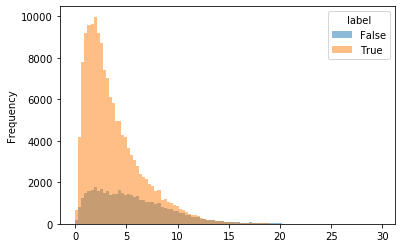

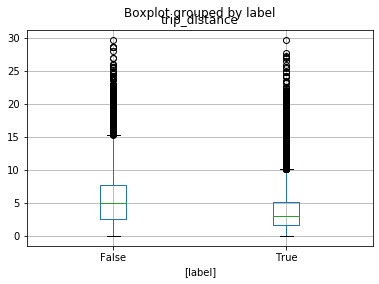

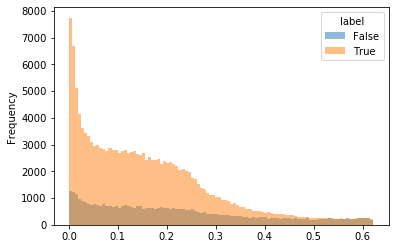

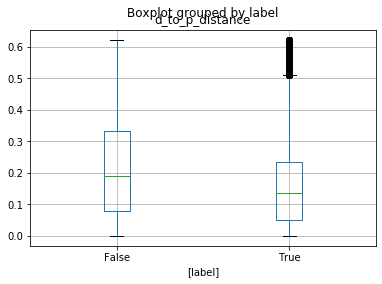

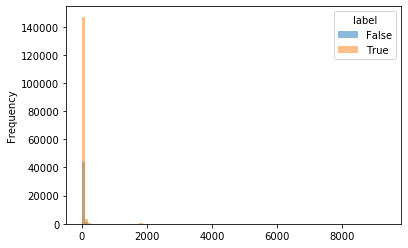

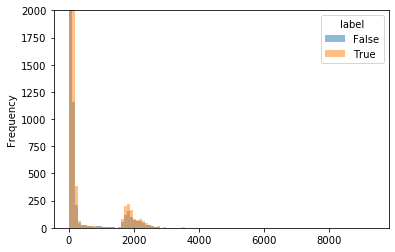

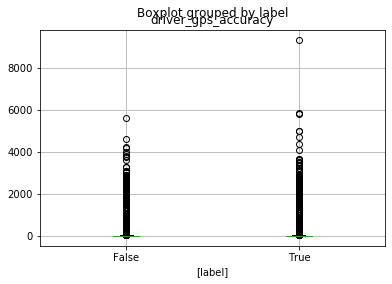

In [61]:
df_traindata.pivot(columns="label", values="trip_distance").plot.hist(bins=100,alpha=0.5)
df_traindata.boxplot(column=['trip_distance'], by=['label'])
df_traindata.pivot(columns="label", values="d_to_p_distance").plot.hist(bins=100,alpha=0.5)
df_traindata.boxplot(column=['d_to_p_distance'], by=['label'])
df_traindata.pivot(columns="label", values="driver_gps_accuracy").plot.hist(bins=100,alpha=0.5)
df_traindata.pivot(columns="label", values="driver_gps_accuracy").plot.hist(bins=100,alpha=0.5,ylim=(0,2000))
df_traindata.boxplot(column=['driver_gps_accuracy'], by=['label'])

all data shows an exponential skew (right-tailed). Decision trees should be able to handle this with no scaling necessary but other algorithms work better with normal distributions. d_to_p_distance cuts off at ~
0.62, which must be a limit set into the algorithm that collected the data. added a histogram with a manual scale to the gps_accuracy as the default scale hid most of the data. most of the data is below 3000, anything above could be considered a flier point. However, there may be some drivers with a high value at all times, if so, removing these fliers would eliminate those drivers from consideration. Even the values around 2000 may be bogus, so maybe we should ignore this column...

start modelling, using gradient boosted decision tree first and do some parameter tuning. view the features used and look at performance metrics

<br>GradientBoostingClassifier(criterion='friedman_mse', init=None,
<br>&nbsp;&nbsp;&nbsp;&nbsp;                           learning_rate=0.5, loss='exponential', max_depth=14,
<br>&nbsp;&nbsp;&nbsp;&nbsp;                           max_features=2, max_leaf_nodes=None,
<br>&nbsp;&nbsp;&nbsp;&nbsp;                           min_impurity_decrease=0.0, min_impurity_split=None,
<br> &nbsp;&nbsp;&nbsp;&nbsp;                          min_samples_leaf=1, min_samples_split=2,
<br> &nbsp;&nbsp;&nbsp;&nbsp;                          min_weight_fraction_leaf=0.0, n_estimators=20,
<br>&nbsp;&nbsp;&nbsp;&nbsp;                           n_iter_no_change=None, presort='auto',
<br> &nbsp;&nbsp;&nbsp;&nbsp;                          random_state=0, subsample=1.0, tol=0.0001,
<br> &nbsp;&nbsp;&nbsp;&nbsp;                          validation_fraction=0.1, verbose=0,
<br> &nbsp;&nbsp;&nbsp;&nbsp;                          warm_start=False)

In [62]:
# this model function is not used in the calculation. Replaced by calculate_predictions_normalized
def calculate_predictions_new(X,X_test_orig):

    X = X[['order_id','trip_distance', 'driver_gps_accuracy', 'd_to_p_distance', 'created_hr', 'created_day', 'driver_id', 'label']].dropna()
    y = X.pop('label')
    X_test = X_test_orig[['trip_distance', 'driver_gps_accuracy', 'd_to_p_distance', 'created_hr', 'created_day', 'driver_id']].dropna()
    state = 12  
    test_size = 0.30 
    train_feature, val_feature, train_label, val_label = train_test_split(X, y, test_size=test_size, random_state=state)
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_features=2, max_depth=4, random_state=0)
    # calculate the model on the train dataset using "fit" function. model name is gb_clf
    gb_clf.fit(train_feature, train_label,sample_weight=None) # X is pandas.core.frame.DataFrame, y is pandas.core.series.Series
    predictions = gb_clf.predict(val_feature)
    # # evaluate model on the validate dataset
    print(gb_clf.score(val_feature, val_label))
    print(pd.Series(gb_clf.feature_importances_, index=train_feature.columns[:]).nlargest(10).plot(kind='barh')) 
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_feature, train_label)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(val_feature, val_label)))
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(val_label, predictions).ravel()
    total = tn+ fp+ fn+ tp
    print("false positive pct:",(fp/total)*100)
    print("tn", "   fp", "   fn", "   tp")
    print(tn, fp, fn, tp)
    print(confusion_matrix(val_label, predictions))
    print("Classification Report")
    print(classification_report(val_label, predictions))
    predictions = gb_clf.predict(X_test)
    predictions_log_proba = gb_clf.predict_log_proba(X_test)
    predictions_proba = gb_clf.predict_proba(X_test)
    X_test_orig['label'] = predictions
    X_test_orig['log_proba_1'] = predictions_log_proba[:, 0]
    X_test_orig['log_proba_2'] = predictions_log_proba[:, 1]
    X_test_orig['proba_1'] = predictions_proba[:, 0]
    X_test_orig['proba_2'] = predictions_proba[:, 1]
    return X_test_orig

In [63]:
def calculate_predictions_normalized(train_orig,test_orig):

    train = train_orig.copy()
    test = test_orig.copy()
    train_feature = train[['trip_distance', 'driver_gps_accuracy', 'd_to_p_distance', 'created_hr', 'created_day', 'driver_id', 'label']].dropna()
    train_label = train_feature.pop('label')
    print(type(train_label))
    test = test_orig[['trip_distance', 'driver_gps_accuracy', 'd_to_p_distance', 'created_hr', 'created_day', 'driver_id']].dropna()
    test_f = test_orig[['order_id','trip_distance', 'driver_gps_accuracy', 'd_to_p_distance', 'created_hr', 'created_day', 'driver_id']].dropna()
    state = 12  
    test_size = 0.30   
        
    # try and normalize the data to values between 0 and 1 to avoid one feature taking over the model in general
    # not necessary in this case for decision trees as they split on absolute values. We do this normalization mainly for 
    # comparing results to other modelling types - overall this model seems robust to most data issues (skew, flier, etc)
    # we won't use the normalized data
    scaler = MinMaxScaler()
    test_array = scaler.fit_transform(test)
    train_feature_array = scaler.transform(train_feature)
    
    print(type(test_array))
    print(type(train_label))
    # numpy.ndarray
    print("2 key data types need to match")
    print(type(train_feature))   # dataframe 
    print(type(train_feature_array)) # ndarray
    
    # change the datatype for driver_id and maybe created_day to category. Doesn't change the model results, 
    # but other types of models would need this step
    train_feature['driver_id'] = train_feature['driver_id'].astype('category')
    train_feature['created_day'] = train_feature['created_day'].astype('category')
    
    # split the data into training and validation datasets
    training_feature, val_feature, training_label, val_label = train_test_split(train_feature, train_label, test_size=test_size, random_state=state)
    # don't use the normalized data
    #training_feature, val_feature, training_label, val_label = train_test_split(train_feature_array, train_label, test_size=test_size, random_state=state)
    print(type(training_feature))
    print(type(training_label))    

    # setup model parameters, change some of the defaults based on benchmarking
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, 
                                       max_depth=14, random_state=0, subsample = 0.5, criterion='mse',
                                       min_samples_split = 10, min_samples_leaf = 10)
    # original fit model
    #gb_clf.fit(training_feature, training_label) # X is pandas.core.frame.DataFrame, y is pandas.core.series.Series
    
    # since a false positive is much worse for booking conversion than a false negative, we should weight them accordingly
    #gb_clf.fit( training_feature, training_label, sample_weight=np.where(training_label == True,0.5,1.0) )
    
    # create the model while trying to balance the dataset, get a much lower false positive pct. In the end this may not change
    # the output much as we only select the best driver in the assignment. 
    # However, in real life we may have to select multiple drivers until we get one that accepts. We may end up selecting one that we predict will fail.
    # In that case it may be better to revert to a different algorithm instead
    
    gb_clf.fit( training_feature, training_label, sample_weight=compute_sample_weight(class_weight='balanced', y=training_label) )
    # use model to predict validation dataset
    predictions = gb_clf.predict(val_feature)
    print(gb_clf.score(val_feature, val_label))
    print(pd.Series(gb_clf.feature_importances_, index=train_feature.columns[:]).nlargest(10).plot(kind='barh')) 
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_feature, train_label)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(val_feature, val_label)))
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(val_label, predictions).ravel()
    total = tn+ fp+ fn+ tp
    print("false positive pct:",(fp/total)*100)
    print("tn", "   fp", "   fn", "   tp")
    print(tn, fp, fn, tp)
    print(confusion_matrix(val_label, predictions))
    print("Classification Report")
    print(classification_report(val_label, predictions))
    predictions = gb_clf.predict(test)
    predictions_log_proba = gb_clf.predict_log_proba(test)
    predictions_proba = gb_clf.predict_proba(test)
    test_f['label'] = predictions
    test_f['log_proba_1'] = predictions_log_proba[:, 0]
    test_f['log_proba_2'] = predictions_log_proba[:, 1]
    test_f['proba_1'] = predictions_proba[:, 0]
    test_f['proba_2'] = predictions_proba[:, 1]
    return test_f

In [64]:
def calculate_predictions_no_ml(test_orig):

    test_copy = test_orig.copy()
    test = test_copy[['order_id', 'trip_distance', 'driver_gps_accuracy', 'd_to_p_distance', 'created_hr', 'created_day', 'driver_id']].dropna()

    idx = test.groupby(['order_id'])['d_to_p_distance'].transform(min) == test['d_to_p_distance']
    final_output = test[idx]
    idx_2 = final_output.groupby(['order_id'])['driver_id'].transform(min) == final_output['driver_id']
    final_output_temp = final_output[idx_2]
    driver_selection_no_ml = final_output_temp[['order_id', 'driver_id']].dropna()
    driver_selection_no_ml.to_csv('driver_selection_no_ml.csv', index=False, header=True)

In [65]:
calculate_predictions_no_ml(df_testdata)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
2 key data types need to match
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
0.6674352846130541
AxesSubplot(0.125,0.125;0.775x0.755)
Accuracy score (training): 0.748
Accuracy score (validation): 0.667
Confusion Matrix:
false positive pct: 11.541050930757061
tn    fp    fn    tp
7096 6857 12902 32559
[[ 7096  6857]
 [12902 32559]]
Classification Report
              precision    recall  f1-score   support

       False       0.35      0.51      0.42     13953
        True       0.83      0.72      0.77     45461

    accuracy                           0.67     59414
   macro avg       0.59      0.61      0.59     59414
weighted avg       0.72      0.67      0.69     59414



,order_id,trip_distance,driver_gps_accuracy,d_to_p_distance,created_hr,created_day,driver_id,label,log_proba_1,log_proba_2,proba_1,proba_2
0,300202530411,2.000,104.100,0.133654,5,2,578486386000,True,-2.646141,-0.073565,0.070924,0.929076
1,300202530411,2.000,22.235,0.257090,5,2,919898718450,True,-1.255101,-0.335538,0.285047,0.714953
2,300202530411,2.000,3.900,0.191197,5,2,566354734208,True,-1.263436,-0.332235,0.282681,0.717319
3,300202530411,2.000,3.000,0.103493,5,2,996326998494,True,-3.106580,-0.045786,0.044754,0.955246
4,300202530411,2.000,4.288,0.101748,5,2,110774820109,False,-0.368530,-1.176845,0.691750,0.308250
...,...,...,...,...,...,...,...,...,...,...,...,...
99975,566874489913,9.791,3.657,0.199748,16,2,170276731500,False,-0.030944,-3.491008,0.969530,0.030470
99976,566874489913,9.791,3.000,0.232090,16,2,874420419957,False,-0.130768,-2.098999,0.877421,0.122579
99977,566874489913,9.791,32.375,0.273917,16,2,398994364727,False,-0.072154,-2.664808,0.930387,0.069613
99978,566874489913,9.791,4.977,0.079580,16,2,629666878477,False,-0.093485,-2.416338,0.910752,0.089248


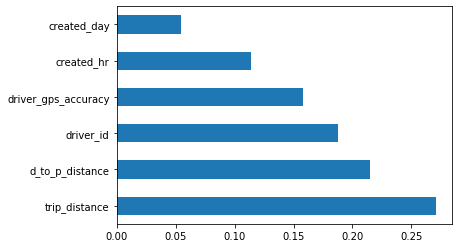

In [66]:
td = calculate_predictions_normalized(df_traindata,df_testdata)
td

look at the cutoff criteria used for labelling from all 4 parameters

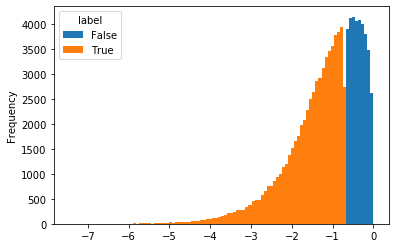

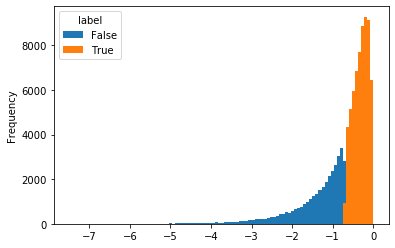

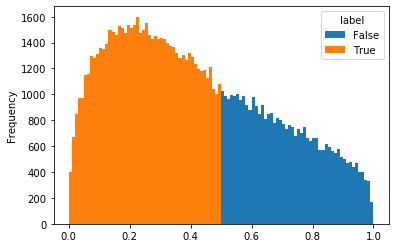

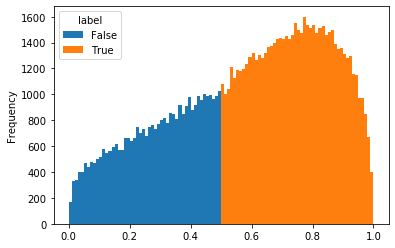

In [67]:
td.pivot(columns="label", values="log_proba_1").plot.hist(bins=100)
td.pivot(columns="label", values="log_proba_2").plot.hist(bins=100)
td.pivot(columns="label", values="proba_1").plot.hist(bins=100)
td.pivot(columns="label", values="proba_2").plot.hist(bins=100)

Validate the findings

output max for each driver

In [68]:
td.query('order_id == 807478573801').sort_values(['proba_1'], ascending=[True])

,order_id,trip_distance,driver_gps_accuracy,d_to_p_distance,created_hr,created_day,driver_id,label,log_proba_1,log_proba_2,proba_1,proba_2
12,807478573801,2.0,27.000,0.350133,23,2,911240047780,True,-1.410018,-0.279898,0.244139,0.755861
13,807478573801,2.0,5.400,0.335107,23,2,129508979863,True,-1.033465,-0.439703,0.355772,0.644228
11,807478573801,2.0,6.349,0.229586,23,2,524075991144,True,-0.925933,-0.504449,0.396162,0.603838
17,807478573801,2.0,26.784,0.108813,23,2,830347879685,True,-0.889877,-0.528830,0.410706,0.589294
16,807478573801,2.0,3.000,0.214845,23,2,363508863542,True,-0.790262,-0.604634,0.453726,0.546274
15,807478573801,2.0,3.900,0.216910,23,2,192437549898,False,-0.623836,-0.767623,0.535885,0.464115
10,807478573801,2.0,3.000,0.272324,23,2,320296641357,False,-0.564160,-0.841271,0.568838,0.431162
19,807478573801,2.0,3.000,0.111353,23,2,749383309234,False,-0.435334,-1.041425,0.647049,0.352951
18,807478573801,2.0,5.146,0.105489,23,2,981561866083,False,-0.281680,-1.404518,0.754515,0.245485
14,807478573801,2.0,4.901,0.057920,23,2,997107872253,False,-0.038814,-3.268324,0.961930,0.038070


In [69]:
idx = td.groupby(['order_id'])['proba_1'].transform(min) == td['proba_1']
final_output = td[idx]

In [70]:
final_output

,order_id,trip_distance,driver_gps_accuracy,d_to_p_distance,created_hr,created_day,driver_id,label,log_proba_1,log_proba_2,proba_1,proba_2
6,300202530411,2.000,86.000,0.097742,5,2,955728734151,True,-3.424485,-0.033108,0.032566,0.967434
12,807478573801,2.000,27.000,0.350133,23,2,911240047780,True,-1.410018,-0.279898,0.244139,0.755861
20,860028367318,2.000,0.010,0.361661,11,2,326468520995,True,-1.532596,-0.243313,0.215974,0.784026
39,149235250409,2.125,3.000,0.002288,15,2,148953337271,True,-2.257414,-0.110508,0.104621,0.895379
44,365552252600,2.125,7.504,0.009999,7,2,500527203055,True,-3.101701,-0.046015,0.044973,0.955027
...,...,...,...,...,...,...,...,...,...,...,...,...
99934,126988985512,9.541,16.541,0.402097,2,2,462421039346,True,-2.344960,-0.100761,0.095851,0.904149
99940,209258157813,9.541,34.277,0.116728,14,2,198723760510,False,-0.390203,-1.129853,0.676919,0.323081
99957,430157268302,9.541,5.425,0.449757,22,2,921246824940,True,-2.530529,-0.082965,0.079617,0.920383
99969,242217169708,9.291,3.900,0.326797,3,2,470935214869,True,-1.756161,-0.189596,0.172707,0.827293


find an order with true labels for some drivers and false labels for other drivers

In [71]:
td.groupby(['order_id','label']).size().to_frame('size').sort_values(['order_id'], ascending=[False]).query('size < 10')

size
order_id     label      
899231424316 True      5
             False     5
899096511800 True      5
             False     5
898964332814 True      6
...                  ...
100257841517 True      8
100241210016 False     1
             True      9
100161922318 False     7
             True      3

[16952 rows x 1 columns]

In [72]:
td.query('order_id == 898566783502').sort_values(['proba_1'], ascending=[True])

,order_id,trip_distance,driver_gps_accuracy,d_to_p_distance,created_hr,created_day,driver_id,label,log_proba_1,log_proba_2,proba_1,proba_2
63607,898566783502,5.998,6.000,0.160055,23,2,159471465288,True,-1.164251,-0.374194,0.312157,0.687843
63601,898566783502,5.998,122.400,0.283257,23,2,232596172740,True,-0.741462,-0.647060,0.476417,0.523583
63604,898566783502,5.998,6.341,0.230698,23,2,140482098304,False,-0.573370,-0.829248,0.563623,0.436377
63606,898566783502,5.998,5.750,0.071391,23,2,572159068141,False,-0.268563,-1.445948,0.764477,0.235523
63600,898566783502,5.998,3.000,0.582564,23,2,322727160155,False,-0.263782,-1.461625,0.768141,0.231859
63602,898566783502,5.998,12.136,0.466094,23,2,920524728568,False,-0.250716,-1.506176,0.778244,0.221756
63603,898566783502,5.998,10.720,0.576795,23,2,495050067660,False,-0.246706,-1.520377,0.781371,0.218629
63605,898566783502,5.998,3.193,0.454918,23,2,956544569779,False,-0.239774,-1.545550,0.786805,0.213195
63608,898566783502,5.998,10.440,0.027301,23,2,968301770249,False,-0.099521,-2.356731,0.905271,0.094729
63609,898566783502,5.998,18.204,0.580533,23,2,891220441488,False,-0.072319,-2.662608,0.930234,0.069766


try to understand and verify the model. for example, why do some drivers look ok but are set to False?

In [73]:
td.query('driver_id == 576663540425').sort_values(['order_id'], ascending=[True])

,order_id,trip_distance,driver_gps_accuracy,d_to_p_distance,created_hr,created_day,driver_id,label,log_proba_1,log_proba_2,proba_1,proba_2
90521,100834726211,7.865,0.01,0.377004,14,2,576663540425,False,-0.014925,-4.212193,0.985186,0.014814
9898,102256738518,1.514,0.01,0.206926,14,2,576663540425,False,-0.444439,-1.024945,0.641184,0.358816
68910,180851546114,7.770,0.01,0.559633,8,2,576663540425,False,-0.199868,-1.708369,0.818839,0.181161
87439,823345464417,2.008,0.01,0.093556,13,2,576663540425,False,-0.584095,-0.815564,0.557610,0.442390
20343,898501286208,7.974,0.01,0.465803,10,2,576663540425,False,-0.017892,-4.032325,0.982267,0.017733


in this case, it seems that trip_distance or d_to_p_distance is the limiting factor for this driver. perhaps he has a bad record with long distance trips?

In [74]:
train_data_t1.query('driver_id == 576663540425').sort_values(['order_id'], ascending=[True])

,order_id,customer_id,driver_id_x,trip_distance,pickup_latitude,pickup_longitude,driver_id,driver_latitude,driver_longitude,driver_gps_accuracy,event_timestamp,d_to_p_distance,label,created_hr,created_day
16368,136734624106,259080909971,576663540425,1.734,-2.970328,104.806871,576663540425,-2.967696,104.801367,0.010,2015-05-10 13:30:57,0.421035,True,13,6
69959,258658537201,222877646254,366014715895,0.750,-2.966474,104.740235,576663540425,-2.966217,104.740070,0.010,2015-05-11 01:59:55,0.021036,False,1,0
135141,404552535611,543261345662,576663540425,3.307,-2.970901,104.802120,576663540425,-2.968816,104.803319,0.010,2015-05-13 06:55:11,0.165499,True,6,2
136633,408118548412,911953569450,576663540425,3.999,-2.968444,104.802944,576663540425,-2.967690,104.801247,0.010,2015-05-17 02:37:47,0.128152,False,2,6
232808,625951710917,490427835097,576663540425,9.090,-2.936314,104.786630,576663540425,-2.935677,104.785200,0.010,2015-05-15 08:42:16,0.108092,True,8,4
280443,733244632416,896697140111,576663540425,2.772,-2.961920,104.817842,576663540425,-2.961917,104.813717,3.048,2015-05-17 23:19:43,0.284909,True,23,6
339315,865434232210,876707807077,576663540425,0.819,-2.968022,104.802703,576663540425,-2.967986,104.802617,0.010,2015-05-11 07:34:45,0.006456,True,7,0


make sure there is only one driver per order

In [75]:
final_output.groupby(['order_id']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).query('size > 1')

,order_id,size
315,125729626401,2
1485,220133321718,2
975,177288104106,2
4259,443924658815,2


found a few dupes, need to check why

In [76]:
final_output.query('order_id == 551261223700')

,order_id,trip_distance,driver_gps_accuracy,d_to_p_distance,created_hr,created_day,driver_id,label,log_proba_1,log_proba_2,proba_1,proba_2
94921,551261223700,1.913,3.216,0.486823,23,2,497537812310,True,-2.835683,-0.06047,0.058678,0.941322


there are some drivers with the exact same performance metric, causing some duplication. I will remove the duplications

In [77]:
idx_2 = final_output.groupby(['order_id'])['driver_id'].transform(min) == final_output['driver_id']
final_output_temp = final_output[idx_2]

In [78]:
final_output_temp

,order_id,trip_distance,driver_gps_accuracy,d_to_p_distance,created_hr,created_day,driver_id,label,log_proba_1,log_proba_2,proba_1,proba_2
6,300202530411,2.000,86.000,0.097742,5,2,955728734151,True,-3.424485,-0.033108,0.032566,0.967434
12,807478573801,2.000,27.000,0.350133,23,2,911240047780,True,-1.410018,-0.279898,0.244139,0.755861
20,860028367318,2.000,0.010,0.361661,11,2,326468520995,True,-1.532596,-0.243313,0.215974,0.784026
39,149235250409,2.125,3.000,0.002288,15,2,148953337271,True,-2.257414,-0.110508,0.104621,0.895379
44,365552252600,2.125,7.504,0.009999,7,2,500527203055,True,-3.101701,-0.046015,0.044973,0.955027
...,...,...,...,...,...,...,...,...,...,...,...,...
99934,126988985512,9.541,16.541,0.402097,2,2,462421039346,True,-2.344960,-0.100761,0.095851,0.904149
99940,209258157813,9.541,34.277,0.116728,14,2,198723760510,False,-0.390203,-1.129853,0.676919,0.323081
99957,430157268302,9.541,5.425,0.449757,22,2,921246824940,True,-2.530529,-0.082965,0.079617,0.920383
99969,242217169708,9.291,3.900,0.326797,3,2,470935214869,True,-1.756161,-0.189596,0.172707,0.827293


In [79]:
final_output_temp.query('order_id == 551261223700')

,order_id,trip_distance,driver_gps_accuracy,d_to_p_distance,created_hr,created_day,driver_id,label,log_proba_1,log_proba_2,proba_1,proba_2
94921,551261223700,1.913,3.216,0.486823,23,2,497537812310,True,-2.835683,-0.06047,0.058678,0.941322


In [80]:
final_output_temp.groupby(['order_id']).size().to_frame('size').reset_index().sort_values(['size'], ascending=[False]).query('size > 1')

,order_id,size


In [81]:
driver_selection = final_output_temp[['order_id', 'driver_id']].dropna()

In [82]:
driver_selection

,order_id,driver_id
6,300202530411,955728734151
12,807478573801,911240047780
20,860028367318,326468520995
39,149235250409,148953337271
44,365552252600,500527203055
...,...,...
99934,126988985512,462421039346
99940,209258157813,198723760510
99957,430157268302,921246824940
99969,242217169708,470935214869


save the data to a file to hand in

In [83]:
driver_selection.to_csv('driver_selection.csv', index=False, header=True)

Summary: 
the model chosen was GradientBoostingClassifier as based on past experience, this technique is most likely to give a good result and not overfit. Key metrics were # of false positives, as this would have the largest negative impact on our process. If we selected a driver thinking he would be successful, but he was not successful, this would have a negative impact on our conversion rate. If we didn't select a driver but he would have been successful, nothing is lost in this case. However, later we should consider if we are not selecting a portion of drivers for any booking, we risk losing drivers, albeit maybe low-performing drivers. But we can use other metrics to find these drivers and deal with them separately. They could be re-trained, put on probation, etc. 